In [1]:
import torch
import torch.autograd.variable as Variable
import torchvision
import torchvision.transforms as transforms
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
import torchvision.utils as utils
from torch.utils.data import Dataset, DataLoader
import torchvision.datasets as datasets
import torchvision.models as models
import torch.utils.data as data

In [2]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
from PIL import Image
from shutil import copyfile
import copy
from collections import namedtuple
import os
import random
import shutil
import time

In [3]:
SEED = 1234

random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

## Data Loading

In [4]:
PATH_TO_FOLDS = 'D:/datasets/ALL_FACE/FairFace-img/'
PATH_TO_IMAGE_FOLDERS = 'D:/datasets/ALL_FACE/FairFace-img/fairface-img-margin025-trainval/'

## Implementing a Custom Dataloader Class

In [5]:
class FairFaceDataset(Dataset):
    
    def __init__(self, csv_file, root_dir, transform):
        self.csv_file = pd.read_csv(csv_file)
        self.root_dir = root_dir
        self.transform = transform
        
    def __len__(self):
        return len(self.csv_file)
    
    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
            
        img_name = os.path.join(self.root_dir, 
                                self.csv_file.iloc[idx, 0])
        image = Image.open(img_name).convert('RGB')
        label_age = self.csv_file.iloc[idx, 1]
        label_gender = self.csv_file.iloc[idx, 2]
        label_race = self.csv_file.iloc[idx, 3]
        
        if self.transform:
            image = self.transform(image)
            
        return {
            'image': image,
            'label_age': label_age,
            'label_gender': label_gender,
            'label_race': label_race
        }

### Transforms

In [6]:
pretrained_size = 224

transforms_list = [
    transforms.Resize(pretrained_size),
    transforms.CenterCrop(pretrained_size),
    transforms.RandomHorizontalFlip(0.5),
    transforms.ToTensor(),
    transforms.RandomCrop(pretrained_size, padding=10),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                        std=[0.229, 0.224, 0.225]),
    transforms.RandomRotation(5)
]

transforms_dict = {
    'train': {
        0: list(transforms_list[i] for i in [0, 1, 3]),        # no transformation
        1: list(transforms_list[i] for i in [0, 1, 2, 3]),     # random horizontal flip
        2: list(transforms_list[i] for i in [0, 4, 2, 3, 5])      # random crop and random horizontal flip
    },
    'val': {
        0: list(transforms_list[i] for i in [0, 1, 3, 5])
    },
    'test': {
        0: list(transforms_list[i] for i in [0, 1, 3, 5])
    }
}

In [7]:
batch_size = 5

train_dataset = FairFaceDataset(csv_file='train_withRace.csv',
                              root_dir = PATH_TO_IMAGE_FOLDERS,
                              transform = transforms.Compose(transforms_dict['train'][2]))

valid_dataset = FairFaceDataset(csv_file='valid_withRace.csv',
                              root_dir = PATH_TO_IMAGE_FOLDERS,
                              transform = transforms.Compose(transforms_dict['val'][0]))

test_dataset = FairFaceDataset(csv_file='test_withRace.csv',
                              root_dir = PATH_TO_IMAGE_FOLDERS,
                              transform = transforms.Compose(transforms_dict['test'][0]))

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

valid_loader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False)

test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [8]:
print(f'Number of training examples: {len(train_dataset)}')
print(f'Number of validation examples: {len(valid_dataset)}')
print(f'Number of test examples: {len(test_dataset)}')

Number of training examples: 69395
Number of validation examples: 10954
Number of test examples: 17349


In [9]:
def normalize_image(image):
    image_min = image.min()
    image_max = image.max()
    image.clamp_(min = image_min, max = image_max)
    image.add_(-image_min).div_(image_max - image_min + 1e-5)
    return image

In [10]:
def plot_images(images, labels, classes, normalize = True):
    
    n_images = len(images)
    
    rows = int(np.sqrt(n_images))
    cols = int(np.sqrt(n_images))
    
    fig = plt.figure(figsize=(10,10))
    
    for i in range(rows*cols):
        
        ax = fig.add_subplot(rows, cols, i+1)
        
        image = images[i]
        
        if normalize:
            image = normalize_image(image)
            
        ax.imshow(image.permute(1, 2, 0).cpu().numpy())
        label = classes[labels[i]]
        ax.set_title(label)
        ax.axis('off')

In [11]:
age_classes = ['0-2', '3-9', '10-19', '20-29', '30-39', '40-49', '50-59', '60-69', '70-']

race_classes = ['White', 'Black', 'Latino', 'East Asian', 'SE Asian', 'Indian', 'Middle Eastern']

gender_classes = ['Male', 'Female']

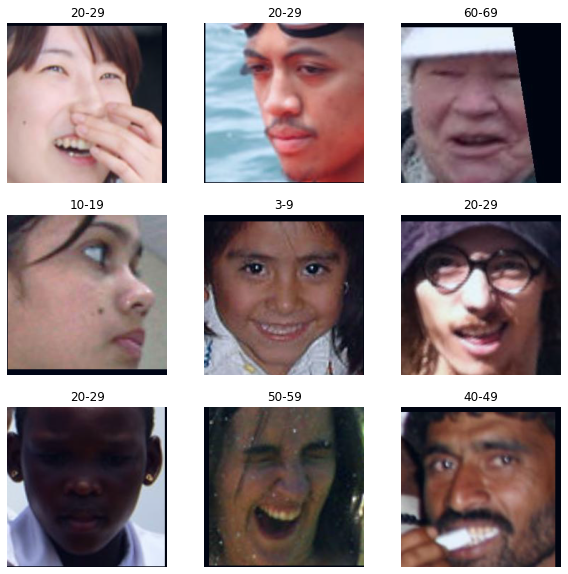

In [13]:
N_IMAGES = 9

images, labels = zip(*[(idx['image'], idx['label_age']) for idx in [train_dataset[i] for i in range(N_IMAGES)]])

plot_images(images, labels, age_classes)

In [14]:
# def weights_init(m):
#     if isinstance(m, nn.Conv2d) or isinstance(m, nn.Linear):
#         nn.init.normal_(m.weight, mean=0, std=1e-2)

In [15]:
import pretrainedmodels
class Net(nn.Module):
    def __init__(self, pretrained):
        super(Net, self).__init__()
        if pretrained is True:
            self.model = pretrainedmodels.__dict__["densenet161"](pretrained="imagenet")
        else:
            self.model = pretrainedmodels.__dict__["densenet161"](pretrained=None)
        self.fc1 = nn.Linear(2208, 9)  #For age class
        self.fc2 = nn.Linear(2208, 2)    #For gender class
        self.fc3 = nn.Linear(2208, 7)    #For race class
        
    def forward(self, x):
        bs, _, _, _ = x.shape
        x = self.model.features(x)
        x = F.adaptive_avg_pool2d(x, 1).reshape(bs, -1)
        label1 = self.fc1(x)
        label2= torch.sigmoid(self.fc2(x))  
        label3 = self.fc3(x)
#         label3= self.fc3(x)
        return {'label1': label1, 'label2': label2, 'label3': label3}

## Specify Loss Function and Optimizer

In [18]:
from torchsummary import summary

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# # model = densenet161().to(device)
model = Net(True)
model = model.to(device)

summary(model, torch.rand((1, 3, 224, 224)))

C:\Users\Shahrullohon\anaconda3\lib\site-packages\torch\nn\functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  ..\c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


Layer (type:depth-idx)                   Output Shape              Param #
├─DenseNet: 1                            []                        --
|    └─Sequential: 2-1                   [-1, 2208, 7, 7]          --
|    |    └─Conv2d: 3-1                  [-1, 96, 112, 112]        14,112
|    |    └─BatchNorm2d: 3-2             [-1, 96, 112, 112]        192
|    |    └─ReLU: 3-3                    [-1, 96, 112, 112]        --
|    |    └─MaxPool2d: 3-4               [-1, 96, 56, 56]          --
|    |    └─_DenseBlock: 3-5             [-1, 384, 56, 56]         751,392
|    |    └─_Transition: 3-6             [-1, 192, 28, 28]         74,496
|    |    └─_DenseBlock: 3-7             [-1, 768, 28, 28]         2,061,504
|    |    └─_Transition: 3-8             [-1, 384, 14, 14]         296,448
|    |    └─_DenseBlock: 3-9             [-1, 2112, 14, 14]        11,548,224
|    |    └─_Transition: 3-10            [-1, 1056, 7, 7]          2,234,496
|    |    └─_DenseBlock: 3-11            [-1

Layer (type:depth-idx)                   Output Shape              Param #
├─DenseNet: 1                            []                        --
|    └─Sequential: 2-1                   [-1, 2208, 7, 7]          --
|    |    └─Conv2d: 3-1                  [-1, 96, 112, 112]        14,112
|    |    └─BatchNorm2d: 3-2             [-1, 96, 112, 112]        192
|    |    └─ReLU: 3-3                    [-1, 96, 112, 112]        --
|    |    └─MaxPool2d: 3-4               [-1, 96, 56, 56]          --
|    |    └─_DenseBlock: 3-5             [-1, 384, 56, 56]         751,392
|    |    └─_Transition: 3-6             [-1, 192, 28, 28]         74,496
|    |    └─_DenseBlock: 3-7             [-1, 768, 28, 28]         2,061,504
|    |    └─_Transition: 3-8             [-1, 384, 14, 14]         296,448
|    |    └─_DenseBlock: 3-9             [-1, 2112, 14, 14]        11,548,224
|    |    └─_Transition: 3-10            [-1, 1056, 7, 7]          2,234,496
|    |    └─_DenseBlock: 3-11            [-1

In [17]:
# model

Net(
  (model): DenseNet(
    (features): Sequential(
      (conv0): Conv2d(3, 96, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (norm0): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu0): ReLU(inplace=True)
      (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (denseblock1): _DenseBlock(
        (denselayer1): _DenseLayer(
          (norm1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu1): ReLU(inplace=True)
          (conv1): Conv2d(96, 192, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (norm2): BatchNorm2d(192, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu2): ReLU(inplace=True)
          (conv2): Conv2d(192, 48, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        )
        (denselayer2): _DenseLayer(
          (norm1): BatchNorm2d(144, eps=1e-05, momentum=0.1, aff

In [20]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)
scheduler = optim.lr_scheduler.MultiStepLR(optimizer, milestones=[40000], gamma=0.1)

In [21]:
def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

Training started
Epoch: 1 | Epoch Time: 57m 38s
Current learning rate is: 0.0001
Training Loss: 3.045402 	Validation Loss: 2.583982
Validation loss decreased (inf --> 2.583982)
Epoch: 2 | Epoch Time: 55m 1s
Current learning rate is: 0.0001
Training Loss: 2.670655 	Validation Loss: 2.434250
Validation loss decreased (2.583982 --> 2.434250)
Epoch: 3 | Epoch Time: 57m 55s
Current learning rate is: 1e-05
Training Loss: 2.475880 	Validation Loss: 2.198804
Validation loss decreased (2.434250 --> 2.198804)
Epoch: 4 | Epoch Time: 54m 3s
Current learning rate is: 1e-05
Training Loss: 2.146469 	Validation Loss: 2.148937
Validation loss decreased (2.198804 --> 2.148937)
Epoch: 5 | Epoch Time: 53m 50s
Current learning rate is: 1e-05
Training Loss: 2.053281 	Validation Loss: 2.112434
Validation loss decreased (2.148937 --> 2.112434)
Epoch: 6 | Epoch Time: 53m 48s
Current learning rate is: 1e-05
Training Loss: 1.992821 	Validation Loss: 2.128532
Epoch: 7 | Epoch Time: 53m 44s
Current learning rate i

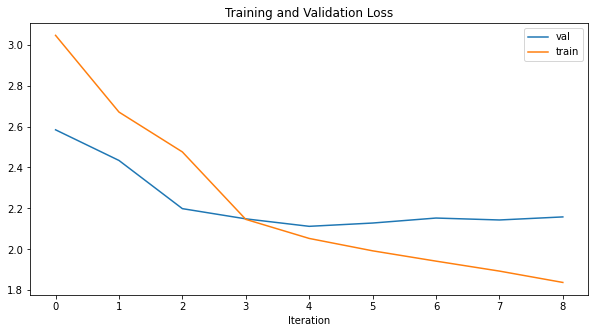

In [22]:
# # number of epochs to train the model
# n_epochs = 10

# valid_loss_min = np.Inf # track change in validation loss
# train_loss_list = []
# valid_loss_list = []

# print('Training started')
# for epoch in range(1, n_epochs):
#     start_time = time.monotonic()
#     # keep track of training and validation loss
#     train_loss = 0.0
#     valid_loss = 0.0
    
#     ###################
#     # train the model #
#     ###################
#     model.train()
#     for i, batch in enumerate(train_loader):
#         # get data and move to GPU
#         image, label1, label2, label3 = batch['image'].to('cuda'), batch['label_age'].to('cuda'), batch['label_gender'].to('cuda'), batch['label_race'].to('cuda')
#         # zero the parameter gradients
#         optimizer.zero_grad()
#         output = model(image)
#         label1_hat = output['label1']
#         label2_hat = output['label2']
#         label3_hat = output['label3']
#         # calculate loss
#         loss1 = criterion(label1_hat, label1.squeeze().long())
#         loss2 = criterion(label2_hat, label2.squeeze().long())
#         loss3 = criterion(label3_hat, label3.squeeze().long())        
#         loss = loss1 + loss2 + loss3
#         # backprop
#         loss.backward()
#         # grad
#         optimizer.step()
#         scheduler.step()
#         train_loss += loss.item()*image.size(0)
        
#     ######################
#     # validate the model #
#     ######################
#     model.eval()
#     for i, batch in enumerate(valid_loader):
#         # get data and move to GPU
#         image, label1, label2, label3 = batch['image'].to('cuda'), batch['label_age'].to('cuda'), batch['label_gender'].to('cuda'), batch['label_race'].to('cuda')
#         output = model(image)
#         label1_hat = output['label1']
#         label2_hat = output['label2']
#         label3_hat = output['label3']
#         # calculate loss
#         loss1 = criterion(label1_hat, label1.squeeze().long())
#         loss2 = criterion(label2_hat, label2.squeeze().long())
#         loss3 = criterion(label3_hat, label3.squeeze().long())
#         loss = loss1 + loss2 + loss3
#         valid_loss += loss.item()*image.size(0)
        
#     # calculate average losses
#     train_loss = train_loss/len(train_loader.sampler)
#     train_loss_list.append(train_loss)
#     valid_loss = valid_loss/len(valid_loader.sampler)
#     valid_loss_list.append(valid_loss)
    
#     end_time = time.monotonic()
#     epoch_mins, epoch_secs = epoch_time(start_time, end_time)
#     print(f'Epoch: {epoch} | Epoch Time: {epoch_mins}m {epoch_secs}s')
#     # print training/validation statistics 
#     for param_group in optimizer.param_groups:
#                 print("Current learning rate is: {}".format(param_group['lr']))    
#     print(f'Training Loss: {train_loss:.6f} \tValidation Loss: {valid_loss:.6f}')
    
#     # save model if validation loss has decreased
#     if valid_loss <= valid_loss_min:
#         print(f'Validation loss decreased ({valid_loss_min:.6f} --> {valid_loss:.6f})')
#         torch.save(model.state_dict(), 'model_prt_withRace.pt')
#         valid_loss_min = valid_loss
        

# plt.figure(figsize=(10,5))
# plt.title('Training and Validation Loss')
# plt.plot(valid_loss_list, label='val')
# plt.plot(train_loss_list, label='train')
# plt.xlabel('Iteration')
# plt.legend()
# plt.show()

In [23]:
model.load_state_dict(torch.load('model_prt_withRace.pt'))

<All keys matched successfully>

### Check Accuracy

In [33]:
def check_accuracy(model, dataloader, c):
#     labels_to_output = ''    
    if c == 'age':
        labels_to_output = 'label1'
    elif c == 'gender':
        labels_to_output = 'label2'
    elif c == 'race':
        labels_to_output = 'label3'
    
    result = {
        'exact_match': 0,
        'total': 0
    }
    if c == 'age':
        result['one_off_match'] = 0

    with torch.no_grad():
        model.eval()
        for i, batch in enumerate(dataloader):
            images, labels = batch['image'].to(device), batch[f'label_{c}'].to(device)
            outputs = model(images)
            outputs = torch.tensor(list(map(lambda x: torch.max(x, 0)[1], outputs[labels_to_output]))).to(device)
            result['total'] += len(outputs)
            result['exact_match'] += sum(outputs == labels).item()
            if c == 'age':
                result['one_off_match'] += (sum(outputs==labels) +
                                            sum(outputs==labels-1) +
                                            sum(outputs==labels+1)).item()

    return result

## Age

In [34]:
accuracy = check_accuracy(model, test_loader, 'age')

print(f"Age Accuracy: {accuracy['exact_match']*100/accuracy['total']}, \tOne-off Accuracy: {accuracy['one_off_match']*100/accuracy['total']}")

Age Accuracy: 59.588448901954, 	One-off Accuracy: 95.98824139719869


### Gender

In [35]:
accuracy = check_accuracy(model, test_loader, 'gender')

print(f"Gender Accuracy: {accuracy['exact_match']*100/accuracy['total']}")

Gender Accuracy: 93.22151132630123


## Race

In [36]:
accuracy = check_accuracy(model, test_loader, 'race')

print(f"Race Accuracy: {accuracy['exact_match']*100/accuracy['total']}")

Race Accuracy: 71.61796068937691


## Confusion Matrix

In [37]:
ROOT_DIR = '.'
IMAGES_PATH = os.path.join(ROOT_DIR, 'images')
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension='png', resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + '.' + fig_extension)
    print('Saving figure', fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

In [49]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

def confusion_matrix_func(data_loader, c, classes):
    # Initialize the prediction and label lists(tensors)
    predlist = torch.zeros(0,dtype=torch.long, device='cpu')
    lbllist = torch.zeros(0,dtype=torch.long, device='cpu')

    if c == 'age':
        labels_to_output = 'label1'
    elif c == 'gender':
        labels_to_output = 'label2'
    elif c == 'race':
        labels_to_output = 'label3'
    
    with torch.no_grad():
        for idx, batch in enumerate(data_loader):
            with torch.no_grad():
                image, target = batch['image'].to(device), batch[f'label_{c}'].to(device)
                outputs = model(image)
                _, preds = torch.max(outputs[labels_to_output], 1)

                predlist = torch.cat([predlist, preds.view(-1).cpu()])
                lbllist = torch.cat([lbllist, target.view(-1).cpu()])

    # confusion matrix
    conf_mat = confusion_matrix(lbllist.numpy(), predlist.numpy())
    print(f'For {c}: \n', conf_mat)
    
    print('#######################################\n\n\n')
    
    # Accuracy for each class label
    print(f'{c} accuracy for each class label')
    class_accuracy = 100 * conf_mat.diagonal()/conf_mat.sum(1)
    print(class_accuracy)
    
    
    print('#######################################\n\n\n')
    print('Conufsion Matrix HeatMap')
    target_names = classes

    cm = confusion_matrix(lbllist.numpy(), predlist.numpy(),)
    # Normalise=
    cmn = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    fig, ax = plt.subplots(figsize=(10,10))
    ax.xaxis.tick_top() # x axis on top
    ax.xaxis.set_label_position('top')
    sns.heatmap(cmn, annot=True, cmap='Blues', fmt='.2f', xticklabels=target_names, yticklabels=target_names)
    plt.title('')
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    save_fig(f'{c} Confusion Matrix')
    plt.show(block=False)

## Age

For age: 
 [[ 266   71    1    0    0    0    0    0    0]
 [  90 1606  296   20    3    2    1    1    0]
 [   0  262  927  622   28    8    1    1    0]
 [   0   21  316 3895  787   93   13    1    0]
 [   0    8   46 1584 1655  568   72    6    0]
 [   0    4    6  182  520  970  380   22    5]
 [   0    1    0    9   59  335  701  127   22]
 [   0    0    0    2    5   38  215  225   80]
 [   0    0    0    0    0    1   14   62   93]]
#######################################



age accuracy for each class label
[78.69822485 79.54432888 50.13520822 75.98517362 42.01574004 46.43370034
 55.90111643 39.82300885 54.70588235]
#######################################



Conufsion Matrix HeatMap
Saving figure age Confusion Matrix


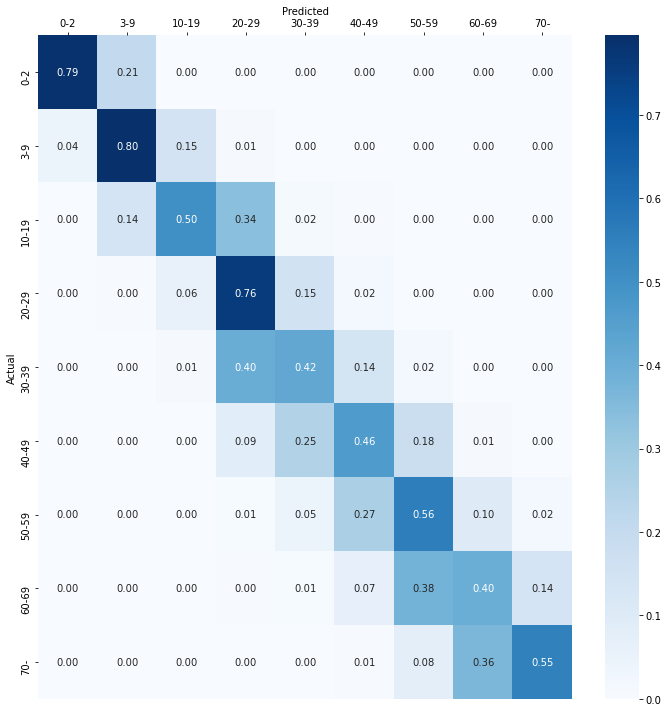

In [50]:
confusion_matrix_func(test_loader, 'age', age_classes)

## Gender

For gender: 
 [[8742  526]
 [ 650 7431]]
#######################################



gender accuracy for each class label
[94.32455762 91.95644103]
#######################################



Conufsion Matrix HeatMap
Saving figure gender Confusion Matrix


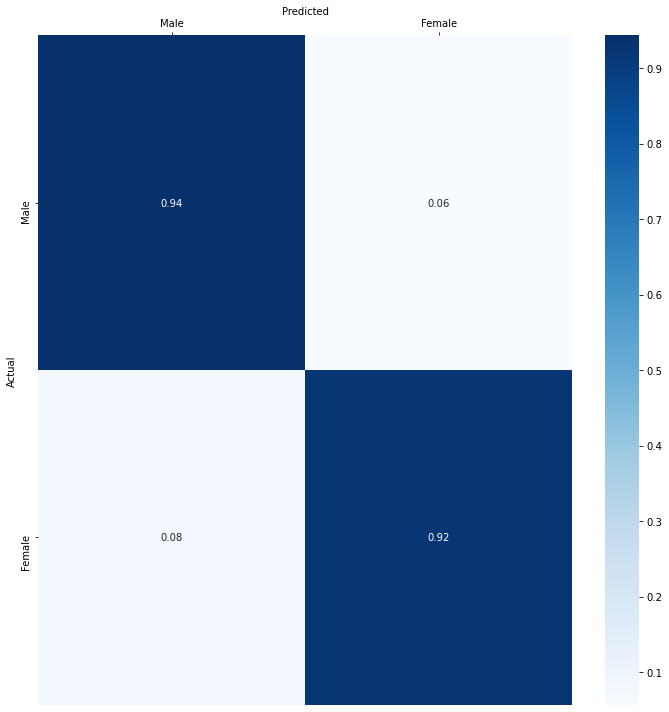

In [51]:
confusion_matrix_func(test_loader, 'gender', gender_classes)

## Race

For race: 
 [[2549   29  276   71   23   38  344]
 [  20 2086  114    8   47  105   17]
 [ 380  173 1308   70  177  259  334]
 [  55   14   40 1969  352    9   14]
 [  21   50  100  516 1371   47   19]
 [  59  152  207   11   72 1839  130]
 [ 290   32  138   11    9   91 1303]]
#######################################



race accuracy for each class label
[76.54654655 87.02544848 48.4265087  80.2690583  64.5480226  74.4534413
 69.53041622]
#######################################



Conufsion Matrix HeatMap
Saving figure race Confusion Matrix


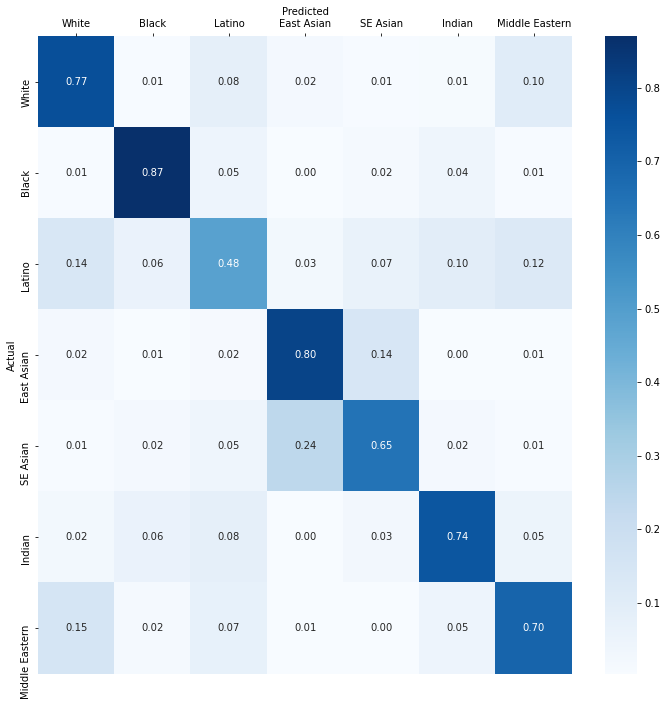

In [52]:
confusion_matrix_func(test_loader, 'race', race_classes)

# Confidence Level

#### We can then get all of the correct predictions, filter them out, and then sort all of the incorrect predictions based on how confident they were on their incorrect prediction.

In [53]:
def get_predictions(model, iterator, c):

    if c == 'age':
        labels_to_output = 'label1'
    elif c == 'gender':
        labels_to_output = 'label2'
    elif c == 'race':
        labels_to_output = 'label3'
    
    model.eval()

    images = []
    labels = []
    probs = []

    with torch.no_grad():

        for batch in iterator:
    
            x = batch['image'].to(device)

            y_pred = model(x)

            y_prob = F.softmax(y_pred[labels_to_output], dim = -1)
            top_pred = y_prob.argmax(1, keepdim = True)

            images.append(x.cpu())
            labels.append(batch[f'label_{c}'].cpu())
            probs.append(y_prob.cpu())

    images = torch.cat(images, dim = 0)
    labels = torch.cat(labels, dim = 0)
    probs = torch.cat(probs, dim = 0)

    return images, labels, probs

In [54]:
def plot_most_incorrect(incorrect, classes, n_images, normalize = True):

    rows = int(np.sqrt(n_images))
    cols = int(np.sqrt(n_images))

    fig = plt.figure(figsize = (25, 20))

    for i in range(rows*cols):

        ax = fig.add_subplot(rows, cols, i+1)
        
        image, true_label, probs = incorrect[i]
        image = image.permute(1, 2, 0)
        true_prob = probs[true_label]
        incorrect_prob, incorrect_label = torch.max(probs, dim = 0)
        true_class = classes[true_label]
        incorrect_class = classes[incorrect_label]

        if normalize:
            image = normalize_image(image)

        ax.imshow(image.cpu().numpy())
        ax.set_title(f'true label: {true_class} ({true_prob:.3f})\n' \
                     f'pred label: {incorrect_class} ({incorrect_prob:.3f})')
        ax.axis('off')
        
    fig.subplots_adjust(hspace=0.4)

## Age Confidence Level

In [55]:
images, labels, probs = get_predictions(model, test_loader, 'age')

pred_labels = torch.argmax(probs, 1)

corrects = torch.eq(labels, pred_labels)

################

incorrect_examples = []

for image, label, prob, correct in zip(images, labels, probs, corrects):
    if not correct:
        incorrect_examples.append((image, label, prob))

incorrect_examples.sort(reverse = True, key = lambda x: torch.max(x[2], dim = 0).values)

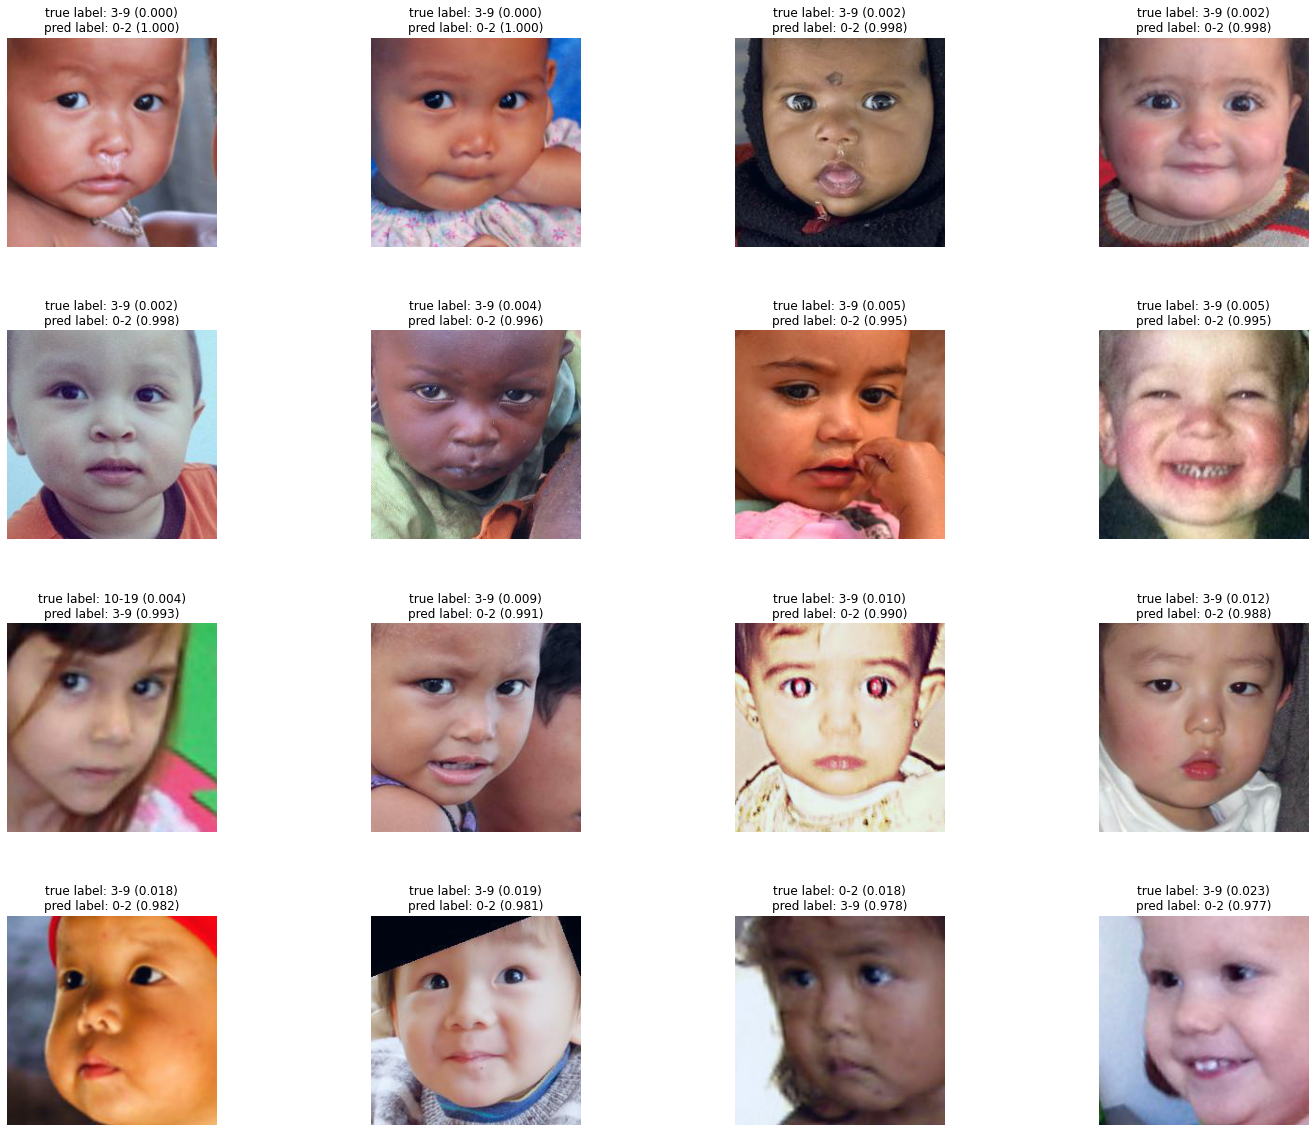

In [56]:
N_IMAGES = 20

plot_most_incorrect(incorrect_examples, age_classes, N_IMAGES)

## Gender Confidence Level

In [57]:
images, labels, probs = get_predictions(model, test_loader, 'gender')

pred_labels = torch.argmax(probs, 1)

corrects = torch.eq(labels, pred_labels)

#####################################
incorrect_examples = []

for image, label, prob, correct in zip(images, labels, probs, corrects):
    if not correct:
        incorrect_examples.append((image, label, prob))

incorrect_examples.sort(reverse = True, key = lambda x: torch.max(x[2], dim = 0).values)

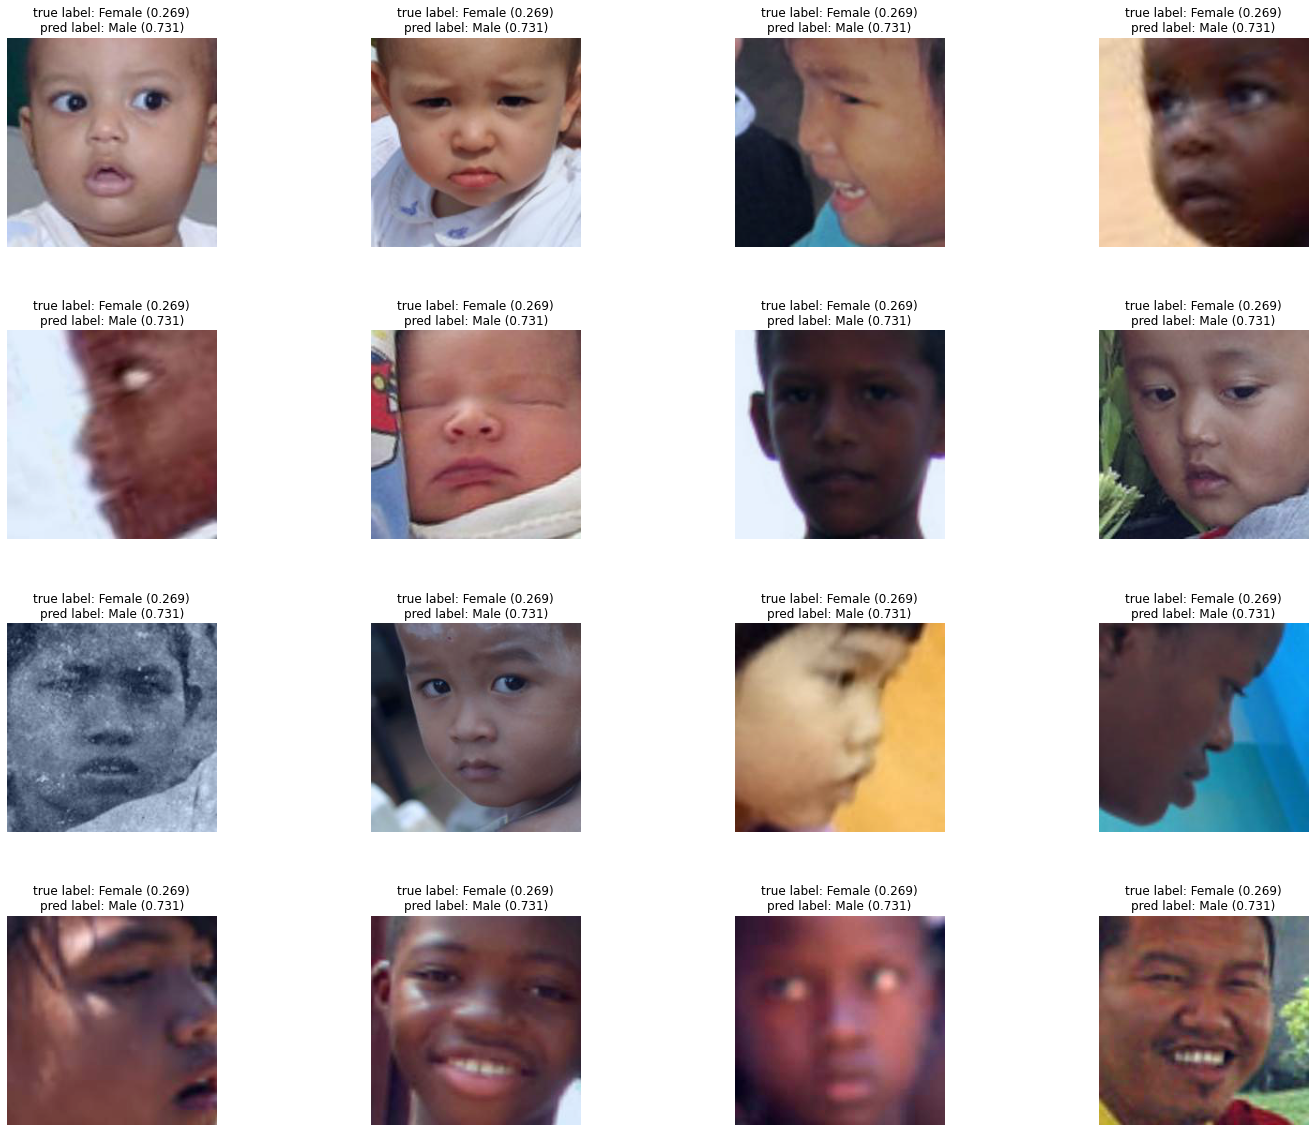

In [58]:
N_IMAGES = 20

plot_most_incorrect(incorrect_examples, gender_classes, N_IMAGES)

## Race Confidence Level

In [59]:
images, labels, probs = get_predictions(model, test_loader, 'race')

pred_labels = torch.argmax(probs, 1)

corrects = torch.eq(labels, pred_labels)

#####################################
incorrect_examples = []

for image, label, prob, correct in zip(images, labels, probs, corrects):
    if not correct:
        incorrect_examples.append((image, label, prob))

incorrect_examples.sort(reverse = True, key = lambda x: torch.max(x[2], dim = 0).values)

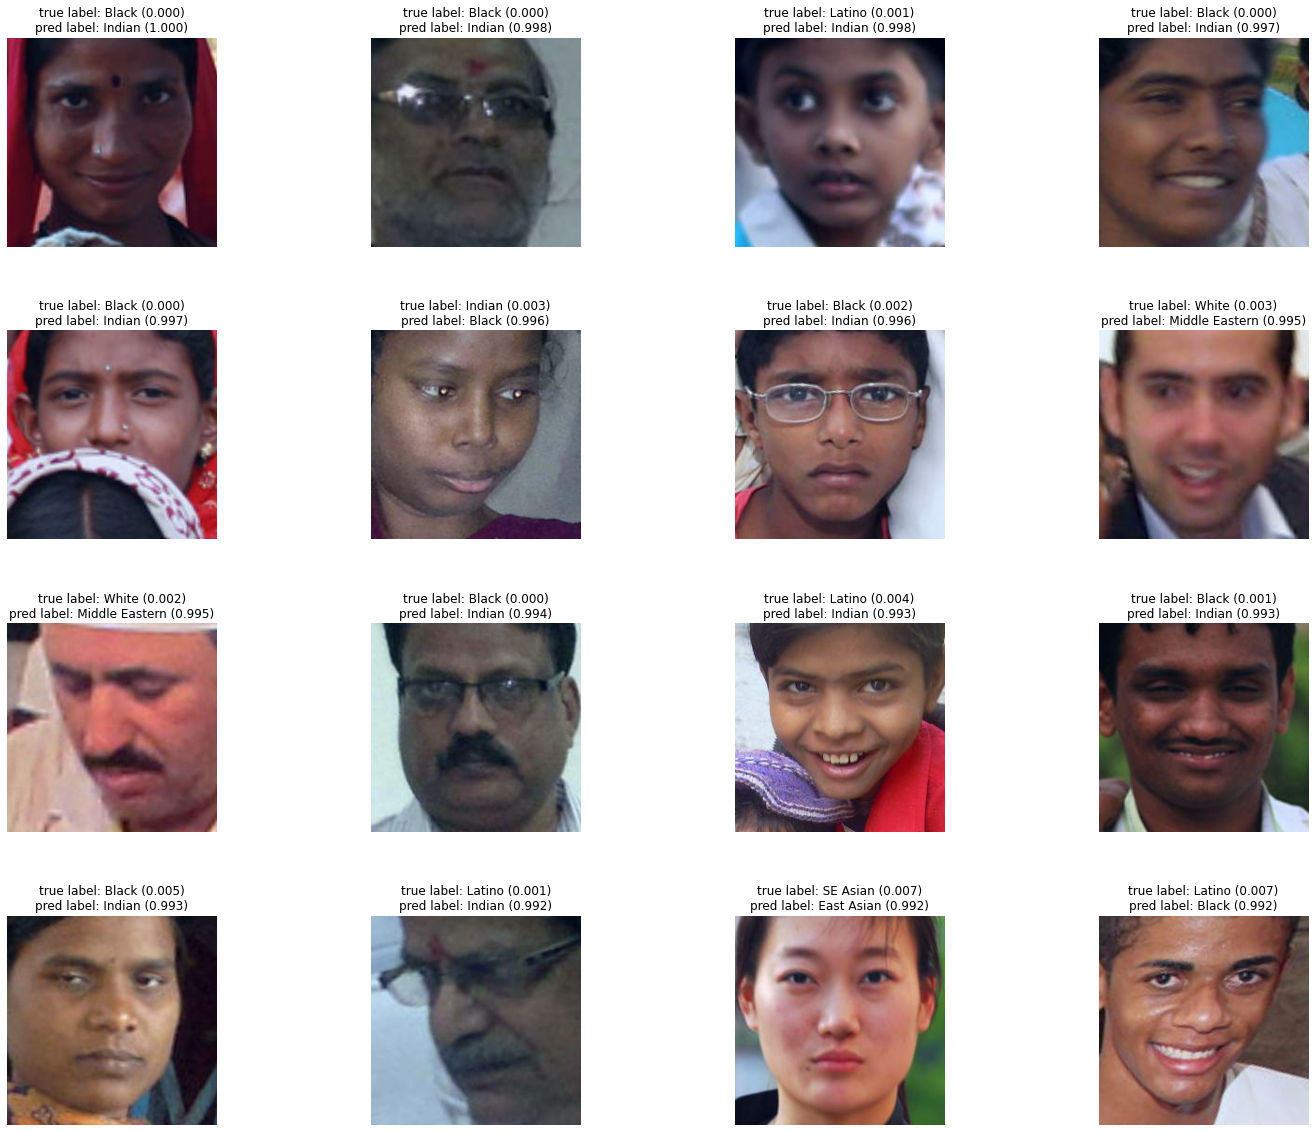

In [60]:
N_IMAGES = 20

plot_most_incorrect(incorrect_examples, race_classes, N_IMAGES)

# Getting Representation

In [63]:
def get_representations(model, iterator, c):
    model.eval()
    
    images = []
    intermediates = []
    labels = []
    
    with torch.no_grad():
        
        for batch in iterator:
            
            x = batch['image'].to(device)
            
            y_pred, _, _ = model(x)
            
            images.append(x.cpu())
            labels.append(batch[f'label_{c}'].cpu())
            
    images = torch.cat(images, dim = 0)
    labels = torch.cat(labels, dim = 0)
    
    return images, labels

In [64]:
outputs_age, labels_age = get_representations(model, valid_loader, 'age')

In [65]:
outputs_gender, labels_gender = get_representations(model, valid_loader, 'gender')

In [66]:
outputs_race, labels_race = get_representations(model, valid_loader, 'race')

## We can perform PCA and tSNE on these representations to plot them in two dimensions.

In [67]:
from sklearn import decomposition
from sklearn import manifold

def get_pca(data, n_components = 2):
    pca = decomposition.PCA()
    pca.n_components = n_components
    pca_data = pca.fit_transform(data)
    return pca_data

In [68]:
def get_tsne(data, n_components = 2, n_images = None):
    
    if n_images is not None:
        data = data[:n_images]
        
    tsne = manifold.TSNE(n_components = n_components, random_state=0)
    tsne_data = tsne.fit_transform(data)
    return tsne_data

In [103]:
hue_age = ['0-2 years', '3-9 years', '10-19 years',
  '20-29 years',
  '30-39 years',
  '40-49 years',
 '50-59 years',
 '60-69 years',
  '70 years and above']

age_dict_labels = {0: '0-2 years', 1: '3-9 years', 2: '10-19 years',  3: '20-29 years',
  4: '30-39 years',
  5: '40-49 years',
 6: '50-59 years',
 7: '60-69 years',
  8: '70 years and above'}

age_str_labels = []

for i in labels_age.tolist():
    age_str_labels.append(age_dict_labels[i])

In [105]:
len(age_str_labels)

10954

In [118]:
def plot_representations(data, labels, classes, c, n_images = None):
    
    if n_images is not None:
        data = data[:n_images]
        labels = labels[:n_images]
        

    fig, ax = plt.subplots(figsize=(15,15))
    sns_plot = sns.scatterplot(ax=ax, data = data, x=data[:, 0], y=data[:, 1], hue = age_str_labels, palette='bright', style=age_str_labels, hue_order=hue_age)
    plt.savefig(f'tSNE_{c}.png')

In [76]:
# output_pca_data = get_pca(outputs)
# plot_representations(output_pca_data, labels, age_classes)

## Age

In [77]:
nsamples, ch, nx, ny = outputs_age.shape
dAge_train = outputs_age.reshape((nsamples, nx*ny*ch))

In [72]:
output_age_tsne = get_tsne(dAge_train)

C:\Users\Shahrullohon\anaconda3\lib\site-packages\seaborn\_core.py:881: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  val in data


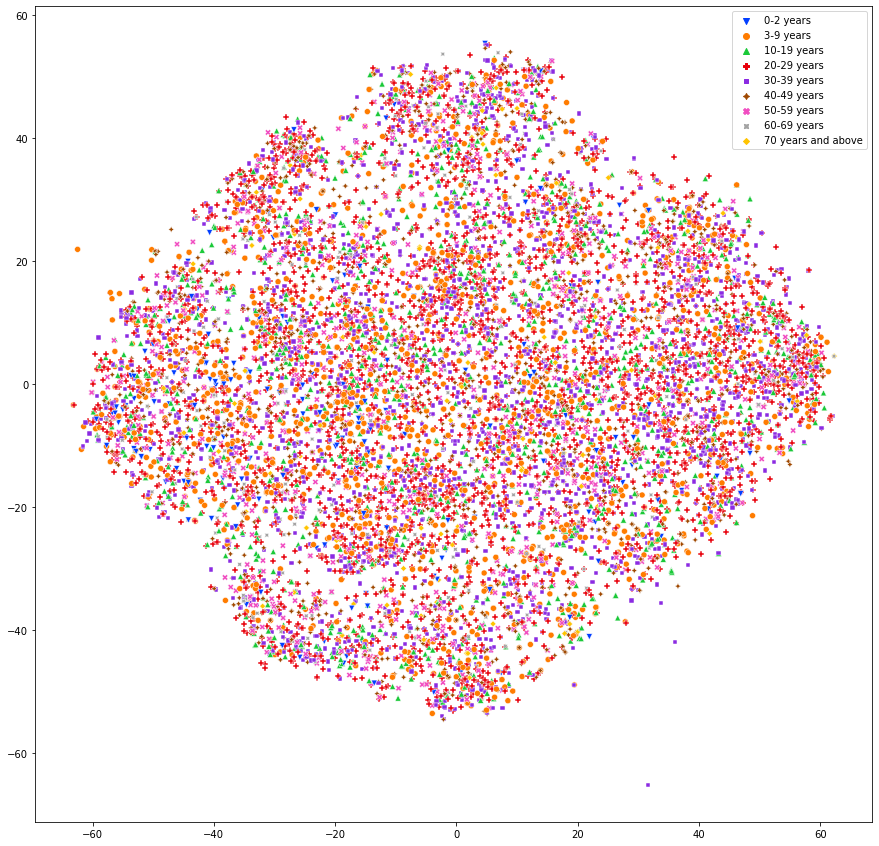

In [119]:
plot_representations(output_age_tsne, labels_age, age_classes, 'age')

## Gender

In [99]:
nsamples, ch, nx, ny = outputs_gender.shape
dGender_train = outputs_gender.reshape((nsamples, nx*ny*ch))

output_gender_tsne = get_tsne(dGender_train)

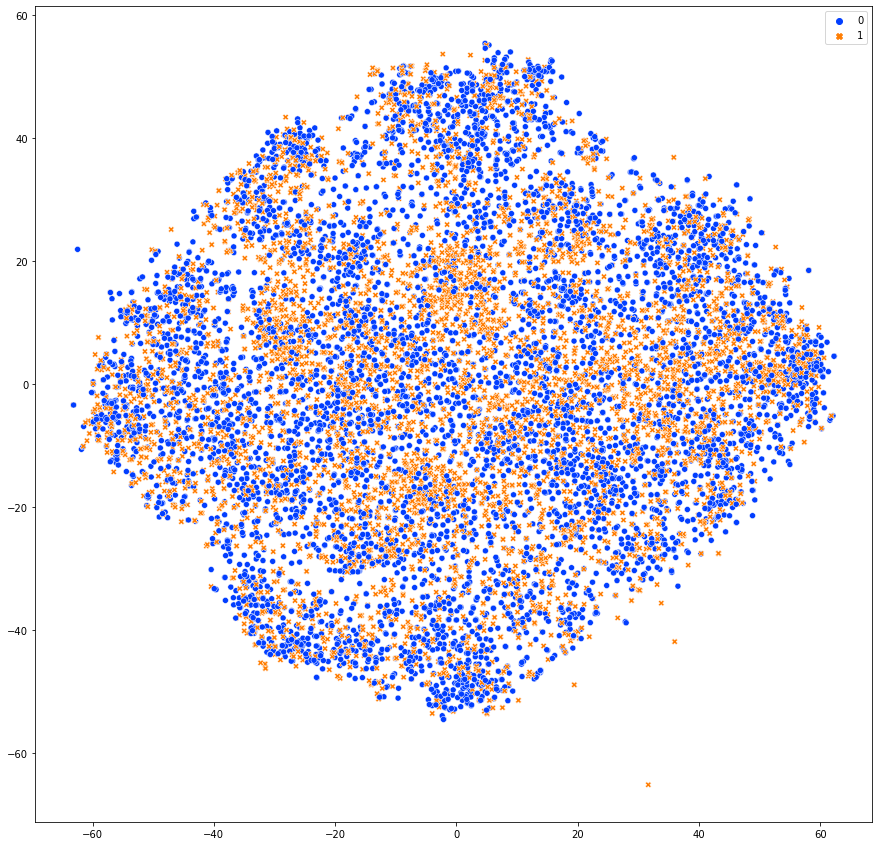

In [100]:
plot_representations(output_gender_tsne, labels_gender, gender_classes, 'gender')

## Race

In [115]:
def plot_representations(data, labels, classes, n_images = None):
    
    if n_images is not None:
        data = data[:n_images]
        labels = labels[:n_images]
        

    fig, ax = plt.subplots(figsize=(15,15))
    sns_plot = sns.scatterplot(ax=ax, data = data, x=data[:, 0], y=data[:, 1], hue = race_str_labels, palette='bright', style=race_str_labels, hue_order=hue_race)
    plt.savefig('tSNE_Race.png')

In [113]:
hue_race = race_classes

race_dict_labels = {0: 'White', 1: 'Black', 2: 'Latino', 3: 'East Asian', 4: 'SE Asian', 5: 'Indian', 6: 'Middle Eastern'}

race_str_labels = []

for i in labels_race.tolist():
    race_str_labels.append(race_dict_labels[i])

In [101]:
nsamples, ch, nx, ny = outputs_race.shape
dRace_train = outputs_race.reshape((nsamples, nx*ny*ch))

output_race_tsne = get_tsne(dRace_train)

C:\Users\Shahrullohon\anaconda3\lib\site-packages\seaborn\_core.py:881: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  val in data


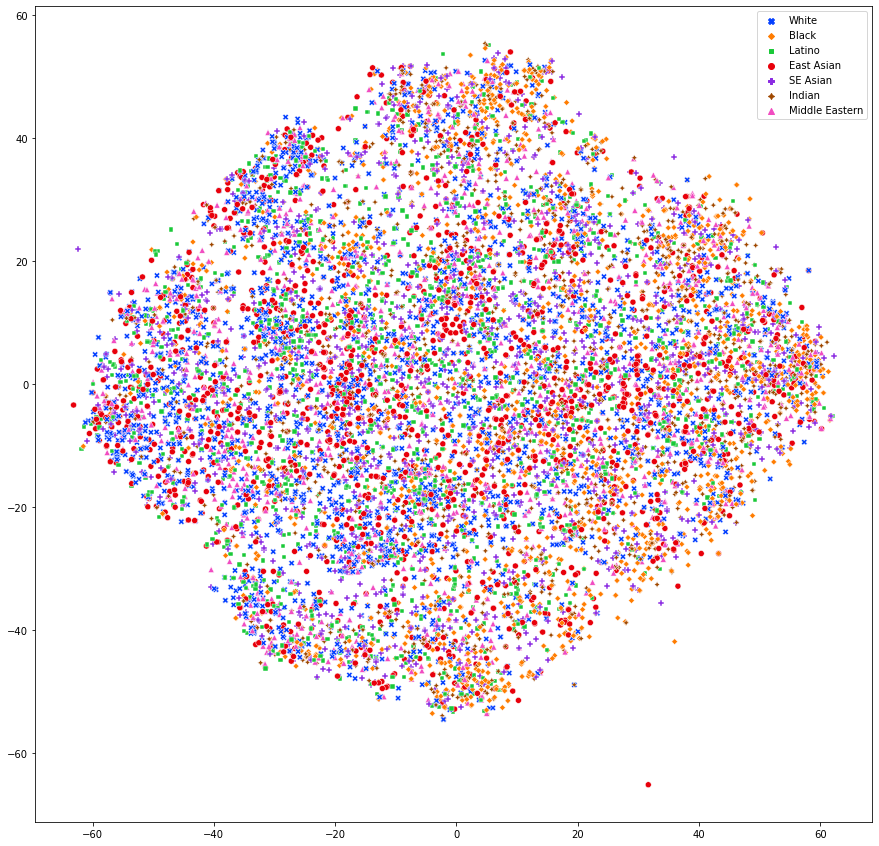

In [116]:
plot_representations(output_race_tsne, labels_race, race_classes)